#  CNN based Sentiment Analysis

Here we use the Convolutional Neural Network (CNN) based NLP model (aka CNet) for the sentiment analysis.

## Data pre-processing and Preparation Process

In [2]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language='en_core_web_sm',
                  batch_first = True)

LABEL = data.LabelField(dtype = torch.float)



In [3]:
import os
import glob
import io
class IMDB(data.Dataset):
    """
    Modified class to load the IMDB dataset directly from a local path,
    now including filenames.
    """
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
        fname_field = data.RawField()
        fields = [('text', text_field), ('label', label_field), ('aname', fname_field)]
        examples = []

        for label in ['pos', 'neg']:
            for fname in glob.iglob(os.path.join(path, label, '*.txt')):
                with io.open(fname, 'r', encoding="utf-8") as f:
                    text = f.read()
                    # Create a cleaner filename (e.g., "pos/123_10.txt")
                    clean_fname = os.path.join(label, os.path.basename(fname))
                    # Add the filename to the data example
                    examples.append(data.Example.fromlist(
                        [text, label, clean_fname], fields))

        super(IMDB, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root_dir=None,
               train='train', test='test', **kwargs):
        """
        This method now constructs the paths and directly
        creates the Dataset objects, bypassing the downloader.
        """

        base_path = '/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar'

        train_path = os.path.join(base_path, train)
        test_path = os.path.join(base_path, test)

        train_data = cls(train_path, text_field, label_field, **kwargs)
        test_data = cls(test_path, text_field, label_field, **kwargs)

        return train_data, test_data


train_data, test_data = IMDB.splits(TEXT, LABEL)

print(f"Length of training data: {len(train_data)}")
print(f"Length of test data: {len(test_data)}")

if len(test_data) > 0:
    print(f"Example filename from test set: {test_data.examples[0].aname}")

random.seed(SEED)

train_data, valid_data = train_data.split()

print(f"Length after split: Train={len(train_data)}, Valid={len(valid_data)}")

Length of training data: 25000
Length of test data: 25000
Example filename from test set: pos/11671_10.txt
Length after split: Train=17500, Valid=7500


Build the vocab and load the pre-trained word embeddings.

In [4]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 399999/400000 [00:20<00:00, 19198.09it/s]


As before, we create the iterators.

In [5]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

cuda


# Designing the deep CNN based NLP Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class CNNNLPMODEL2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)

        #embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

Then, initializing our model.

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNNNLPMODEL2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Lets see the paprameters of our model for efficiency.

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has',count_parameters(model), 'trainable parameters')

The model has 2620801 trainable parameters


Next, we'll load the pre-trained embeddings

In [9]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.6018, -0.4828, -0.0202,  ...,  0.3944, -0.2940,  0.0201],
        [ 0.4606, -0.1632,  0.3935,  ..., -0.1767, -0.1790,  0.2659],
        [-0.0062,  0.3436,  0.9390,  ...,  0.0027, -0.7396, -0.5918]])

Then zero the initial weights of the unknown and padding tokens.

In [10]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Train the Model

In [11]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [12]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

Now defining different fucntions for training and evaluation.

In [13]:
train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    #batch = next(iterator.__iter__())
    #print(batch.text)
    #print(batch.aname)
    #print(batch.text)
    #usman: check eval

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

#        train_loss_values.append(loss.item())

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note:** again, as we are now using dropout, we must remember to use model.eval() to ensure the dropout is "turned off" while evaluating.

In [14]:
from sklearn.metrics import precision_score, recall_score
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    #sssssssss
    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            #sssdsdssd
            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            #valid_loss_values.append(loss.item())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch.text, batch.label

            # 👇 move them to device
            text = text.to(device)
            labels = labels.to(device)

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, labels)

            preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc += (preds == labels).sum().item() / len(labels)

    # compute precision, recall
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), precision, recall


Let's define our function to tell us how long epochs take.

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [16]:
N_EPOCHS = 50

train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)

    train_acc_values.append(train_acc)
    valid_acc_values.append(valid_acc)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Model2Reviews.pt')

    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 0 m  20 s
	Train Loss:  0.6583345174571894  | Train Acc:  60.366429899730825 %
	 Val. Loss:  0.5244430851633266  |  Val. Acc:  77.55561440677965 %
Epoch:  2  | Epoch Time: 0 m  18 s
	Train Loss:  0.4326309181042831  | Train Acc:  79.97018379451585 %
	 Val. Loss:  0.3544254710866233  |  Val. Acc:  84.82521186440678 %
Epoch:  3  | Epoch Time: 0 m  18 s
	Train Loss:  0.307475642620647  | Train Acc:  87.11141165155564 %
	 Val. Loss:  0.32101706023943627  |  Val. Acc:  86.29502118644068 %
Epoch:  4  | Epoch Time: 0 m  18 s
	Train Loss:  0.22685888442244842  | Train Acc:  91.20177269852074 %
	 Val. Loss:  0.30426696356449084  |  Val. Acc:  87.11599576271186 %
Epoch:  5  | Epoch Time: 0 m  18 s
	Train Loss:  0.1604759404911612  | Train Acc:  94.06364051094891 %
	 Val. Loss:  0.3131568594125368  |  Val. Acc:  87.23516949152543 %
Epoch:  6  | Epoch Time: 0 m  19 s
	Train Loss:  0.11038549873896324  | Train Acc:  96.14181440242015 %
	 Val. Loss:  0.34844172086124703  |  

In [17]:
print(len(train_loss_values))
print(len(valid_loss_values))
print(train_loss_values)
print(valid_loss_values)

print(len(train_acc_values))
print(len(valid_acc_values))
print(train_acc_values)
print(valid_acc_values)

with open('the_model2_performance.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_acc_values])
    filehandle.write(tLoss)


    #for listitem in train_loss_values:
     #   filehandle.write(listitem)

50
50
[0.6583345174571894, 0.4326309181042831, 0.307475642620647, 0.22685888442244842, 0.1604759404911612, 0.11038549873896324, 0.07860489390844846, 0.051422090507554315, 0.03739512917232176, 0.02977615724195366, 0.022096963735283727, 0.02077305001371547, 0.014474252982823056, 0.013356913159852915, 0.011660965375158677, 0.01128225095071286, 0.008853186807980978, 0.008784593852675762, 0.008025223536167912, 0.0071020040904442834, 0.008170727241752893, 0.007595901327151601, 0.007143569772985099, 0.006751537590894027, 0.006805348745855268, 0.008760001473178718, 0.004564680345040465, 0.006760022110248316, 0.006209762324969412, 0.006180163219048891, 0.004070334614095246, 0.0049258904080880395, 0.0029916978033562524, 0.0029604761167174197, 0.0025054404377027636, 0.0025620636844762945, 0.003757379884862291, 0.0035948690761259485, 0.005802616675415252, 0.0031590977431978965, 0.00285872999302228, 0.002956559850022762, 0.003566240110902248, 0.003973786484737313, 0.005315672250333551, 0.0017663569

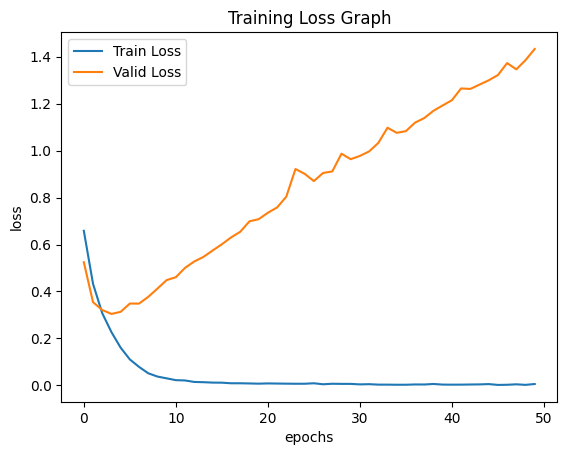

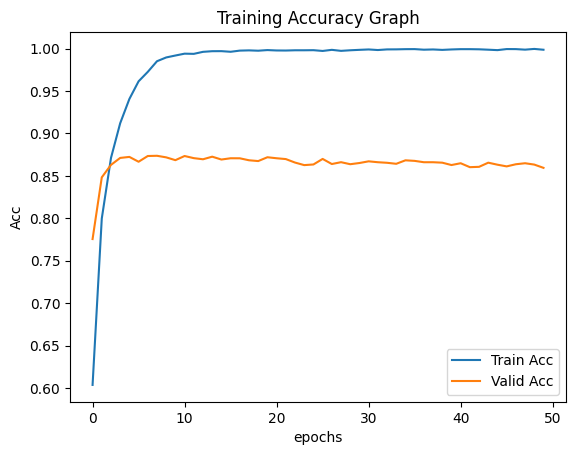

In [18]:
from matplotlib import pyplot as plt


train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]


# open file and read the content in a list
with open('the_model2_performance.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()

    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    valid_loss_values=[float(i) for i in filecontents[1].split(',')]
    train_acc_values=[float(i) for i in filecontents[2].split(',')]
    valid_acc_values=[float(i) for i in filecontents[3].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.plot(valid_loss_values,label='Valid Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.plot(valid_acc_values,label='Valid Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [38]:
# Load the best model
model.load_state_dict(torch.load('Model2Reviews.pt'))
model.eval()

import csv

with open('sentiment_results_model2_reviews.csv', mode='w', newline='', encoding='utf-8') as sent_file:
    file_writer = csv.writer(sent_file)
    file_writer.writerow(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'])

    for batch in test_iterator:
        text, labels = batch.text.to(device), batch.label.to(device)
        predictions = torch.round(torch.sigmoid(model(text).squeeze(1)))

        # Write each example in the batch
        for i in range(len(predictions)):
            file_writer.writerow([batch.aname[i], int(predictions[i].item()), int(labels[i].item())])

test_loss, test_acc, test_prec, test_recall = evaluate_test(model, test_iterator, criterion)

print('Test Loss: ',str(test_loss),' | Acc:',str(test_acc*100),'% ', 'Precision: ',str(test_prec), 'Recall: ',str(test_recall))
print('Results are also written in the csv file')


Test Loss:  0.33276707997255006  | Acc: 85.76166879795396 %  Precision:  0.8486739469578783 Recall:  0.8704
Results are also written in the csv file


**Now generating word cloud.**

Index(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'], dtype='object')


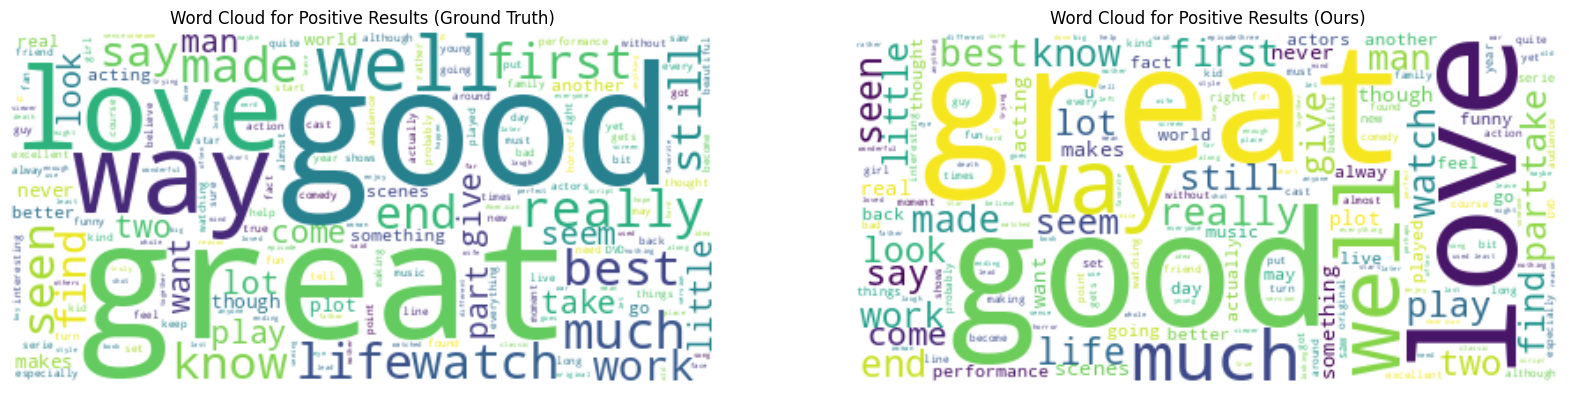

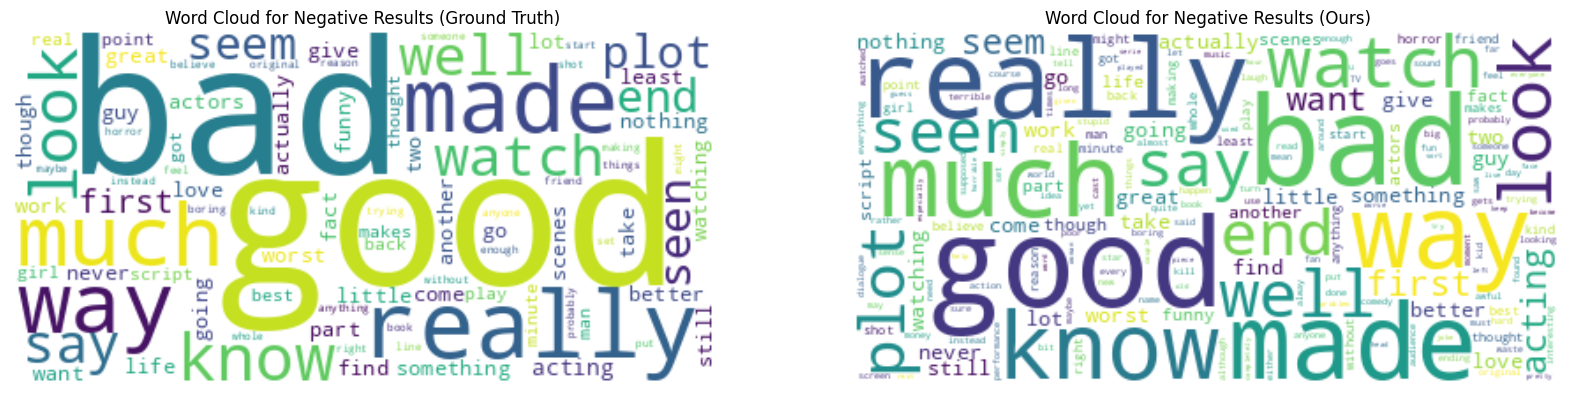

In [42]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("./sentiment_results_model2_reviews.csv")

allTextPos=""
allTextPosGT=""

print(model_df.columns)

for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==1.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPosGT=allTextPosGT+" "+data

for ind in model_df[model_df['Our Prediction']==1.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPos=allTextPos+" "+data



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




allTextNeg=""
allTextNegGT=""

for ind in model_df[model_df['Our Prediction']==0.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         allTextNeg=allTextNeg+" "+data


for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==0.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextNegGT=allTextNegGT+" "+data


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()